# Single-Trial ERP Heatmap Visualization

In [1]:
import numpy as np
import pandas as pd
import mne
import os

import matplotlib.pyplot as plt
import seaborn as sns
import logging

from Function import *

In [2]:
# === Configure logging ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================
PATH_PREPROCESSED_DATA = '../data/preprocessData'
PATH_RAW_DATA_BIDS = '../data/data_raw_BIDS'
PATH_BEHAVIOR_DATA_JOINT = '../results/joint-modeling/data_joint_modeling_all.csv'

BIDS_TASK_LABEL = '_task-MAAT'
BIDS_EEG_SUFFIX = '_eeg'
BIDS_BEH_SUFFIX = '_beh'

# Load all behavioral data to get max RT
data_behavior_all = pd.read_csv(PATH_BEHAVIOR_DATA_JOINT)
MAX_RT_SEC = data_behavior_all['probe_rt'].max()  # Maximum reaction time across all subjects (in seconds)

STIM_MARKER = 'Stimulus/S  8'  
RESP_MARKER = 'Stimulus/S 12'  

CHANNEL_INDICES = [36, 37, 38]
SAMPLING_RATE = 256

SUBJECT_IDS = [f'sub-STSWD{i}' for i in [
    1117,1118,1120,1126,1131,1132,1135,1136,
    1151,1160,1164,1167,1169,1172,1173,1178,
    1182,1215,1216,1219,1223,1227,1228,1233,
    1234,1237,1240,1243,1245,1247,1250,
    1252,1257,1261,1265,1266,1268,1270,1276,1281]] #1239,

In [3]:
# =============================================================================
#  Prepare data for plot
# =============================================================================
# Load the index of excluded subjects
excluded_sub_df = pd.read_csv(os.path.join(PATH_RAW_DATA_BIDS, 'sub_excluded.csv'), header=None)
excluded_sub_set = set(excluded_sub_df.iloc[:, 0].tolist())

# Load the index of invalid trials
data_invalid_trials_full = pd.read_csv(os.path.join(PATH_RAW_DATA_BIDS, 'all_invalid_trials.csv'), header=0)

data_all_trials = []
for sub_idx in SUBJECT_IDS:
    if sub_idx in excluded_sub_set:
        continue
    # Load indices of outlier trials
    data_invalid_trial = data_invalid_trials_full[data_invalid_trials_full['subj_idx'] == sub_idx]
    index_invalid_trial = data_invalid_trial['invalid_trial_index'].to_list()

    # Set an new format of idx
    sub_idx = sub_idx.replace('STSWD', '')
    
    logger.info(f"Processing subject: {sub_idx}")

    # === Step 1: load eeg and behavior data ===
    # Set path to load behavior and eeg data
    path_eeg = os.path.join(
        PATH_PREPROCESSED_DATA,
        sub_idx, 
        'eeg',
        sub_idx+BIDS_TASK_LABEL+BIDS_EEG_SUFFIX+'.vhdr')
    
    path_behavior = path_beh = os.path.join(
        PATH_PREPROCESSED_DATA, 
        sub_idx,
        'beh',
        sub_idx+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    
    assert os.path.exists(path_eeg), f"EEG file not found: {path_eeg}"
    assert os.path.exists(path_behavior), f"Behavior file not found: {path_behavior}"

    # Load behavior and EEG data
    data_behavior = pd.read_csv(path_beh, sep='\t', header=0)
    data_behavior['rt'] = data_behavior['probe_rt']              # convert RT into seconds

    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=True)
    data_eeg = eeg_bids.get_data()*1e6 
    data_erp = data_eeg[CHANNEL_INDICES, :].mean(axis=0)
    max_timestamps = data_eeg.shape[1]

    # Extract response triggers from annotations
    events, events_id = mne.events_from_annotations(eeg_bids)
    event_id_resp = {RESP_MARKER: events_id[RESP_MARKER]}

    # Remove the first of any consecutive response triggers
    events_resp_booleans= (events[:, 2] == event_id_resp[RESP_MARKER])
    events_remove = np.concatenate([events_resp_booleans[:-1] & events_resp_booleans[1:], [False]])
    events_clean = events[~events_remove]

    events_response_clean = events_clean[events_clean[:, 2] == event_id_resp[RESP_MARKER]]

    # Extract valid response triggers

    events_response_valid = np.delete(events_response_clean, index_invalid_trial, axis=0)
    # Validate trial count consistency
    assert len(data_behavior) == len(events_response_valid), f"{sub_idx}: Behavioral and EEG data are misaligned."

    # === Step 2: Merge and calculate the start and end timestamps for each trial ===
    # Merge behavioral and trigger data
    merged_index_timestamps = pd.DataFrame({
        'subject_id': data_behavior['subj_idx'].values,
        'reaction_time_sec': data_behavior['rt'].values,
        'trigger_sample': events_response_valid[:, 0]
    })
  
    # Compute epoch boundaries per trial
    # Epoch starts at: trigger - (RT + 0.5 sec) → aligns t = -0.5 sec to stimulus onset
    # Epoch ends at:   trigger + (MAX_RT - RT) → ensures all trials end at same absolute time relative to max RT
    merged_index_timestamps['epoch_start_sample'] = np.round(
        np.maximum(0, merged_index_timestamps['trigger_sample'] - (merged_index_timestamps['reaction_time_sec'] + 0.5) * SAMPLING_RATE)
    ).astype(int)

    merged_index_timestamps['epoch_end_sample'] = np.round(
        np.minimum(max_timestamps, merged_index_timestamps['trigger_sample'] + (MAX_RT_SEC - merged_index_timestamps['reaction_time_sec']) * SAMPLING_RATE)
    ).astype(int)


    # === Step 3: Extract ERP segment for each trial ===
    for _, trial_row in merged_index_timestamps.iterrows():
        start_idx = int(trial_row['epoch_start_sample'])
        end_idx = int(trial_row['epoch_end_sample'])

        erp_segment = data_erp[start_idx:end_idx]

        trial_record = {
            'subject_id': trial_row['subject_id'],
            'reaction_time_sec': trial_row['reaction_time_sec']
        }
        for time_idx, amplitude in enumerate(erp_segment):
            trial_record[f't_{time_idx}'] = amplitude

        data_all_trials.append(trial_record)

# === Step 4: Assemble final DataFrame ===
data_single_trial_plot = pd.DataFrame(data_all_trials)
data_single_trial_plot = data_single_trial_plot.fillna(0)           # Clean data: replace NaNs with 0
print("Final ERP DataFrame shape:", data_single_trial_plot.shape)

2025-12-13 11:22:08,790 - INFO - Processing subject: sub-1118


Extracting parameters from ../data/preprocessData/sub-1118/eeg/sub-1118_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 980540  =      0.000 ...  3830.234 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:09,817 - INFO - Processing subject: sub-1120


Extracting parameters from ../data/preprocessData/sub-1120/eeg/sub-1120_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 797695  =      0.000 ...  3115.996 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:10,565 - INFO - Processing subject: sub-1126


Extracting parameters from ../data/preprocessData/sub-1126/eeg/sub-1126_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 815605  =      0.000 ...  3185.957 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:11,107 - INFO - Processing subject: sub-1131


Extracting parameters from ../data/preprocessData/sub-1131/eeg/sub-1131_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 841543  =      0.000 ...  3287.277 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:11,712 - INFO - Processing subject: sub-1132


Extracting parameters from ../data/preprocessData/sub-1132/eeg/sub-1132_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 801259  =      0.000 ...  3129.918 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:12,330 - INFO - Processing subject: sub-1135


Extracting parameters from ../data/preprocessData/sub-1135/eeg/sub-1135_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 786349  =      0.000 ...  3071.676 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:12,825 - INFO - Processing subject: sub-1164


Extracting parameters from ../data/preprocessData/sub-1164/eeg/sub-1164_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 857517  =      0.000 ...  3349.676 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:13,373 - INFO - Processing subject: sub-1167


Extracting parameters from ../data/preprocessData/sub-1167/eeg/sub-1167_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 790384  =      0.000 ...  3087.438 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:13,922 - INFO - Processing subject: sub-1215


Extracting parameters from ../data/preprocessData/sub-1215/eeg/sub-1215_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 803204  =      0.000 ...  3137.516 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:14,433 - INFO - Processing subject: sub-1216


Extracting parameters from ../data/preprocessData/sub-1216/eeg/sub-1216_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 914789  =      0.000 ...  3573.395 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:15,010 - INFO - Processing subject: sub-1233


Extracting parameters from ../data/preprocessData/sub-1233/eeg/sub-1233_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 813639  =      0.000 ...  3178.277 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 16')]


2025-12-13 11:22:15,573 - INFO - Processing subject: sub-1234


Extracting parameters from ../data/preprocessData/sub-1234/eeg/sub-1234_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 812379  =      0.000 ...  3173.355 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14')]


2025-12-13 11:22:16,084 - INFO - Processing subject: sub-1240


Extracting parameters from ../data/preprocessData/sub-1240/eeg/sub-1240_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 870071  =      0.000 ...  3398.715 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:16,651 - INFO - Processing subject: sub-1250


Extracting parameters from ../data/preprocessData/sub-1250/eeg/sub-1250_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 820991  =      0.000 ...  3206.996 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:17,207 - INFO - Processing subject: sub-1261


Extracting parameters from ../data/preprocessData/sub-1261/eeg/sub-1261_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 896204  =      0.000 ...  3500.797 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:17,780 - INFO - Processing subject: sub-1266


Extracting parameters from ../data/preprocessData/sub-1266/eeg/sub-1266_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 782888  =      0.000 ...  3058.156 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:18,318 - INFO - Processing subject: sub-1270


Extracting parameters from ../data/preprocessData/sub-1270/eeg/sub-1270_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 797931  =      0.000 ...  3116.918 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


2025-12-13 11:22:18,858 - INFO - Processing subject: sub-1281


Extracting parameters from ../data/preprocessData/sub-1281/eeg/sub-1281_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 788940  =      0.000 ...  3081.797 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Final ERP DataFrame shape: (4576, 575)


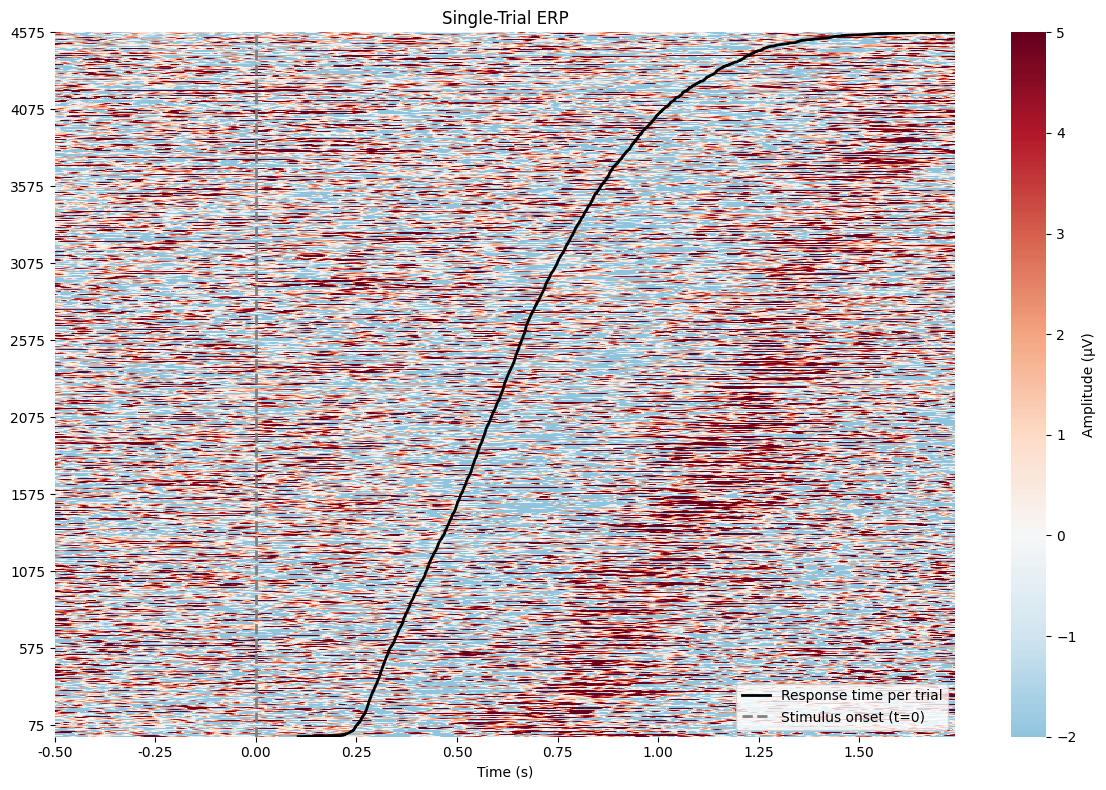

In [4]:
# =============================================================================
#  Plot single trials heatmap
# =============================================================================
# Identify ERP timepoint columns
erp_timepoint_columns = [col for col in data_single_trial_plot.columns if col.startswith('t_')]

# Sort trials by reaction time (longest RT at top of heatmap)
sorted_df = data_single_trial_plot.sort_values('reaction_time_sec', ascending=False).reset_index(drop=True)
erp_matrix = sorted_df[erp_timepoint_columns].values
n_trials, n_timepoints = erp_matrix.shape

# Create heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    erp_matrix,
    cmap='RdBu_r',
    center=0,
    xticklabels=False,
    yticklabels=False,
    vmin=-2,
    vmax=5,
    cbar_kws={'label': 'Amplitude (µV)'}
)

# === Step 1: Overlay reaction time trajectory ===
rt_array = sorted_df['reaction_time_sec'].to_numpy()
# Time axis: t = -0.5 sec corresponds to column index 0
# Therefore, RT (relative to stimulus) occurs at: t = RT → column = (RT + 0.5) * SAMPLING_RATE
rt_x_positions = (rt_array + 0.5) * SAMPLING_RATE
y_positions = np.arange(n_trials)  # y=0 at top, y=n_trials-1 at bottom
ax.plot(rt_x_positions, y_positions, color='black', linewidth=2, label='Response time per trial')

# === Step 2: Set x-axis time labels ===
# Total duration covered: from t = -0.5 sec to t = (n_timepoints / SAMPLING_RATE) - 0.5 sec
time_vector_sec = np.arange(-0.5, (n_timepoints / SAMPLING_RATE) - 0.5 + 1e-9, 0.25)
x_tick_indices = ((time_vector_sec + 0.5) * SAMPLING_RATE).astype(int)

# Ensure indices are within bounds
valid_ticks = (x_tick_indices >= 0) & (x_tick_indices < n_timepoints)
ax.set_xticks(x_tick_indices[valid_ticks])
ax.set_xticklabels([f"{t:.2f}" for t in time_vector_sec[valid_ticks]])

# === Step 3: Set y-axis trial labels ===
# Label every 500 trials
y_tick_step = 500
y_tick_positions = np.arange(0, n_trials, y_tick_step)

# For correct visual alignment with "trial 0 at bottom",
# we plot y = n_trials - 1 - i, but since we want labels to reflect actual trial order from bottom,
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(n_trials - 1 - y_tick_positions)  # Trial index as shown (0 = first row = top)

# === Step 4: Mark stimulus onset (t = 0) ===
t0_column_index = int(0.5 * SAMPLING_RATE)  # Because t = -0.5 → col 0, so t=0 → col 250
ax.axvline(x=t0_column_index, color='grey', linewidth=2, linestyle='--', label='Stimulus onset (t=0)')

# === Step 5: Finalize plot ===
ax.set_xlabel('Time (s)')
ax.set_title('Single-Trial ERP')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()